# Дисперсионный анализ

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import scipy.stats as st
import seaborn as sns

import statsmodels.api as sm

from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statsmodels.stats.weightstats  import ttest_ind

## Лечение гипертонии
**Maxwell S.E., Delaney H.D. Designing Experiments and Analyzing Data: A Model Comparison Perspective. (1990). Глава 8, стр. 325.**

72 пациента проходили лечение от гипертонии. Для лечения использовались три вида лекарств, при этом их эффект изучался как при использовании специальной диеты, так и в её отсутствии; кроме того, в половине случаев применялась психотерапия. Данные — артериальное давление пациента по окончании лечения.

Требуется сравнить эффективность методов лечения гипертонии.

### Чтение данных

In [2]:
data = pd.read_csv('data/hyper.txt', delimiter='\t')
data.head()

,biofeedback,diet,drug,pressure
0,present,absent,1,170
1,present,absent,1,175
2,present,absent,1,165
3,present,absent,1,180
4,present,absent,1,160


In [3]:
data.sample(10, random_state=42)

,biofeedback,diet,drug,pressure
4,present,absent,1,160
62,absent,absent,3,190
18,present,present,2,164
0,present,absent,1,170
28,present,absent,3,204
50,absent,absent,2,217
10,present,present,1,181
34,present,present,3,180
12,present,absent,2,186
54,absent,present,2,171


In [4]:
data.describe(include='all')

,biofeedback,diet,drug,pressure
count,72,72,72.000000,72.000000
unique,2,2,NaN,NaN
top,absent,absent,NaN,NaN
freq,36,36,NaN,NaN
mean,NaN,NaN,2.000000,184.500000
std,NaN,NaN,0.822226,17.838872
min,NaN,NaN,1.000000,152.000000
25%,NaN,NaN,1.000000,170.750000
50%,NaN,NaN,2.000000,182.500000
75%,NaN,NaN,3.000000,198.250000


### Трехфакторный дисперсионный анализ для пациентов

In [6]:
# "~" значит равно
# Суть: все, что слева, пытаемся оценить через то, что справа
# "С" — категориальный признак
lm = ols('pressure ~ C(biofeedback) * C(diet) * C(drug)', data=data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(biofeedback),1.0,2048.0,2048.000000,13.072340,6.150719e-04
C(diet),1.0,5202.0,5202.000000,33.204255,3.053308e-07
C(drug),2.0,3675.0,1837.500000,11.728723,5.018624e-05
C(biofeedback):C(diet),1.0,32.0,32.000000,0.204255,6.529374e-01
C(biofeedback):C(drug),2.0,259.0,129.500000,0.826596,4.424565e-01
C(diet):C(drug),2.0,903.0,451.500000,2.881915,6.381527e-02
C(biofeedback):C(diet):C(drug),2.0,1075.0,537.500000,3.430851,3.883423e-02
Residual,60.0,9400.0,156.666667,NaN,NaN


In [7]:
table[table['PR(>F)'] < 0.05]

,df,sum_sq,mean_sq,F,PR(>F)
C(biofeedback),1.0,2048.0,2048.0,13.072340,6.150719e-04
C(diet),1.0,5202.0,5202.0,33.204255,3.053308e-07
C(drug),2.0,3675.0,1837.5,11.728723,5.018624e-05
C(biofeedback):C(diet):C(drug),2.0,1075.0,537.5,3.430851,3.883423e-02


Трехфакторное взаимодействие есть $\rightarrow$ рассмартриваем дальше!

#### Построим графики взаимодействий

Формула для двухфакторного взаимодействия:

$$X_{ijk} = \mu + \alpha_i + \beta_j + \gamma_{ij} + \varepsilon_{ijk},$$
$$i = 1, ..., K_1,\ j = 1, ..., K_2,\ k = 1, ..., n.$$

- $\mu$ -- общее среднее значение признака,
- $\alpha_i$ -- воздействие уровня $i$ фактора $f_1$,
- $\beta_j$ -- воздействие уровня $j$ фактора $f_2$,
- $\gamma_{ij}$ -- дополнительное воздействие комбинации уровней $i$ и $j$ факторов $f_1$ и $f_2$,
- $\varepsilon_{ijk}$ -- случайные независимые одинаково распределенные ошибки

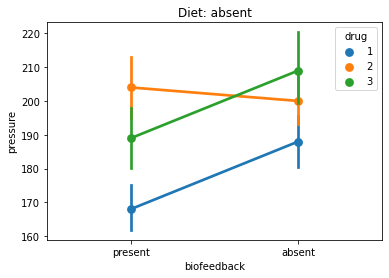

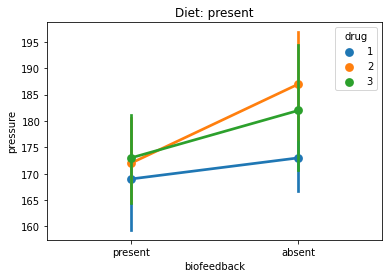

In [8]:
plt.title('Diet: absent')
_ = sns.pointplot(x="biofeedback", y="pressure", data=data.loc[data['diet']=='absent'], hue='drug')
plt.show()

plt.title('Diet: present')
_ = sns.pointplot(x="biofeedback", y="pressure", data=data.loc[data['diet']=='present'], hue='drug')
plt.show()

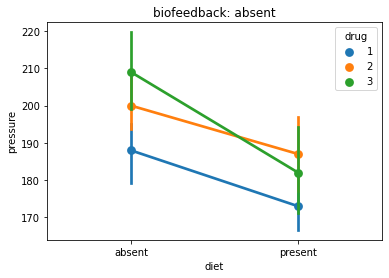

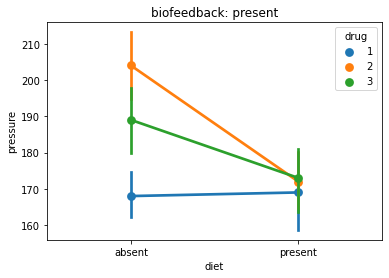

In [9]:
plt.title('biofeedback: absent')
_ = sns.pointplot(x="diet", y="pressure", data=data.loc[data['biofeedback']=='absent'], hue='drug')
plt.show()

plt.title('biofeedback: present')
_ = sns.pointplot(x="diet", y="pressure", data=data.loc[data['biofeedback']=='present'], hue='drug')
plt.show()

Тройное взаимодействие значимо, поэтому разделим выборку по одному из признаков.

### Двухфакторный дисперсионный анализ для пациентов, проходящих психотерапию

In [12]:
lm = ols('pressure ~  C(diet) * C(drug)',data=data.loc[data['biofeedback']=='present']).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(diet),1.0,2209.0,2209.000000,15.248504,0.000496
C(drug),2.0,2342.0,1171.000000,8.083295,0.001556
C(diet):C(drug),2.0,1634.0,817.000000,5.639669,0.008334
Residual,30.0,4346.0,144.866667,NaN,NaN


Есть значимое межфакторное взаимодействие.

#### Графики

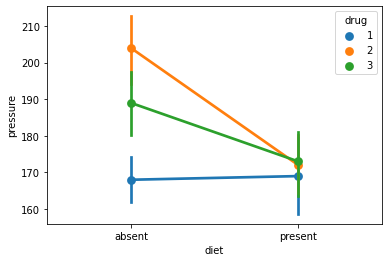

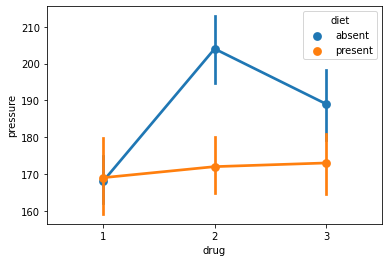

In [13]:
_ = sns.pointplot(x="diet", y="pressure", data=data.loc[data['biofeedback']=='present'], hue='drug')
plt.show()
_ = sns.pointplot(x="drug", y="pressure", data=data.loc[data['biofeedback']=='present'], hue='diet')
plt.show()

Поэтому снова поделим выборку.

### Однофакторный анализ для пациентов, проходящих психотерапию и сидящих на диете:

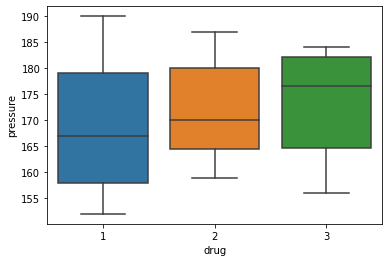

In [14]:
_ = sns.boxplot(x='drug', y='pressure', data=data[(data['biofeedback']=='present') & (data['diet']=='present')])
plt.show()

In [15]:
lm =  ols('pressure ~ C(drug)',data=data.loc[(data['biofeedback']=='present') & (data['diet']=='present')]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(drug),2.0,52.0,26.0,0.164141,0.850126
Residual,15.0,2376.0,158.4,NaN,NaN


Ожидаемый p-value: ```~0.850126```

### Однофакторный анализ для пациентов, проходящих психотерапию и не сидящих на диете:

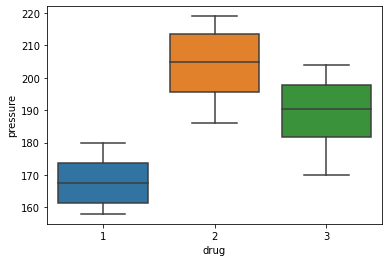

In [16]:
_ = sns.boxplot(x='drug', y='pressure', data=data[(data['biofeedback']=='present') & (data['diet']=='absent')])

In [17]:
lm =  ols('pressure ~ C(drug)',data=data.loc[(data['biofeedback']=='present') & (data['diet']=='absent')]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(drug),2.0,3924.0,1962.000000,14.939086,0.000269
Residual,15.0,1970.0,131.333333,NaN,NaN


Ожидаемый p-value: ```~0.000269```

#### Исследуем различия в воздействии между группами

In [19]:
# Смотрим, как меняется давление от лекарства
# Фиксируем: наличие психотерапии и диеты
mc = MultiComparison(data.loc[(data['biofeedback']=='present') & (data['diet']=='absent')]['pressure'],
                     data.loc[(data['biofeedback']=='present') & (data['diet']=='absent')]['drug'])
result = mc.tukeyhsd()

print(result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2     36.0  0.001  18.8206 53.1794   True
     1      3     21.0 0.0163   3.8206 38.1794   True
     2      3    -15.0 0.0918 -32.1794  2.1794  False
-----------------------------------------------------


Препарат 1 значимо эффективнее двух других.

**Только для тех, кто поесещали психотерапию и сидели на диете.**

### Двухфакторный дисперсионный анализ для пациентов, не проходящих психотерапию:

In [20]:
lm = ols('pressure ~ C(diet) * C(drug)',data=data[data['biofeedback']=='absent']).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(diet),1.0,3025.0,3025.000000,17.956074,0.000198
C(drug),2.0,1592.0,796.000000,4.724970,0.016448
C(diet):C(drug),2.0,344.0,172.000000,1.020973,0.372422
Residual,30.0,5054.0,168.466667,NaN,NaN


Межфакторное взаимодействие незначимо:

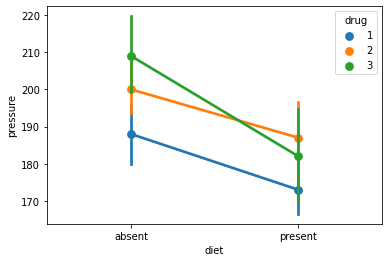

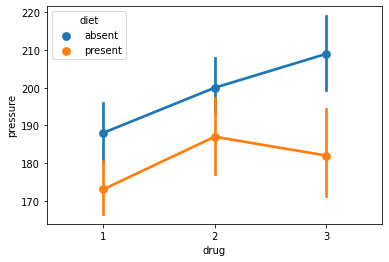

In [21]:
_ = sns.pointplot(x="diet", y="pressure", data=data[data['biofeedback']=='absent'], hue='drug')
plt.show()

_ = sns.pointplot(x="drug", y="pressure", data=data[data['biofeedback']=='absent'], hue='diet')
plt.show()

#### Исследуем попарные различия в воздействии каждого из лекарств в зависимости от диеты

In [23]:
subset = data[data.diet == 'absent']
mc = MultiComparison(subset['pressure'], subset['drug'])
result = mc.tukeyhsd()
print(result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2     24.0  0.001   9.8936 38.1064   True
     1      3     21.0 0.0025   6.8936 35.1064   True
     2      3     -3.0 0.8504 -17.1064 11.1064  False
-----------------------------------------------------


In [24]:
subset = data[data.diet == 'present']
mc = MultiComparison(subset['pressure'], subset['drug'])
result = mc.tukeyhsd()
print(result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2      8.5 0.2994  -5.3036 22.3036  False
     1      3      6.5 0.4892  -7.3036 20.3036  False
     2      3     -2.0    0.9 -15.8036 11.8036  False
-----------------------------------------------------


### Итого:

* если пациент не проходит психотерапию, соблюдение диеты приводит к значимому уменьшению давления при приёме любого из трёх препаратов;
* эффективность всех трёх препаратов неразличима для пациентов, сидящих на диете и проходящих психотерапию;
* для пациентов, проходящих психотерапию и не сидящих на диете, препарат 1 эффективнее в среднем примерно на 20 мм. рт. ст.
* Чтобы сделать другие возможные выводы (например, оценить эффекты психотерапии и эффект диеты для тех, кто проходит психотерапию), нужно разбить трёхфакторный анализ по двум другим признакам.


## Рост певцов хора
**Cleveland W. S. (1993) Visualizing Data. Summit, New Jersey: Hobart Press.**

В 1979 году было опрошено 235 членов нью-йоркской ассоциации хорового пения, для каждого из них известен рост и регистр голоса. Меняется ли средний рост вместе с регистром?



In [27]:
data =  sm.datasets.get_rdataset('singer', 'lattice').data
data.sample(5)

,height,voice.part
168,68,Tenor 2
136,68,Tenor 1
146,68,Tenor 1
175,71,Bass 1
71,63,Alto 1


Переименуем 2 колонку и переведем рост в сантиметры

In [28]:
data.columns = ['height', 'voice']
data['height'] *= 2.54

In [30]:
data.describe(include='all')

,height,voice
count,235.000000,235
unique,NaN,8
top,NaN,Bass 1
freq,NaN,39
mean,170.936596,NaN
std,9.714908,NaN
min,152.400000,NaN
25%,165.100000,NaN
50%,170.180000,NaN
75%,177.800000,NaN


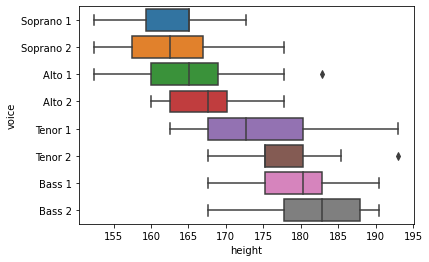

In [31]:
_ = sns.boxplot(x='height', y='voice', data=data)
plt.show()

### Однофакторный дисперсионный анализ:

In [32]:
lm = ols('height ~ C(voice)', data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(voice),7.0,12911.303982,1844.471997,45.641891,5.617050e-40
Residual,227.0,9173.483695,40.411822,NaN,NaN


Ожидаемое p-value ~ `5.6e-40`

In [33]:
data.groupby('voice').mean()

,height
voice,
Alto 1,164.809714
Alto 2,167.734074
Bass 1,179.623590
Bass 2,181.316923
Soprano 1,163.195000
Soprano 2,162.475333
Tenor 1,175.018095
Tenor 2,177.558095


### Критерий Краскела-Уоллиса о равенстве средних:

In [34]:
st.kruskal(*data.groupby('voice').groups.values())

KruskalResult(statistic=229.8276956364947, pvalue=5.399740283982908e-46)

### Критерий Бартлетта о равенстве дисперсий:

In [35]:
st.bartlett(*data.groupby('voice').groups.values())

BartlettResult(statistic=18.417706445737398, pvalue=0.010221018996479406)

### HSD Тьюки:

#### Существенность различий между группами

In [43]:
mc = MultiComparison(data['height'], data['voice'])
result = mc.tukeyhsd()

print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj   lower    upper   reject
------------------------------------------------------------
   Alto 1    Alto 2   2.9244 0.6065  -2.0572   7.9059  False
   Alto 1    Bass 1  14.8139  0.001  10.2856  19.3422   True
   Alto 1    Bass 2  16.5072  0.001  11.4718  21.5426   True
   Alto 1 Soprano 1  -1.6147    0.9  -6.2314    3.002  False
   Alto 1 Soprano 2  -2.3344 0.7959  -7.1733   2.5046  False
   Alto 1   Tenor 1  10.2084  0.001   4.8401  15.5767   True
   Alto 1   Tenor 2  12.7484  0.001   7.3801  18.1167   True
   Alto 2    Bass 1  11.8895  0.001   7.0205  16.7586   True
   Alto 2    Bass 2  13.5828  0.001    8.239  18.9267   True
   Alto 2 Soprano 1  -4.5391 0.0989  -9.4904   0.4123  False
   Alto 2 Soprano 2  -5.2587 0.0423 -10.4179  -0.0995   True
   Alto 2   Tenor 1    7.284 0.0027   1.6253  12.9427   True
   Alto 2   Tenor 2    9.824  0.001   4.1653  15.4827   True
   Bass 1    Bass 2   1.

### Итог:

- в целом, тип голоса существенно влияет на рост
- различия в этом влиянии присутствуют лишь между некоторыми парами голосов

## Влияние витамина C на рост зубов морских свинок
**Crampton E. W. (1947) The growth of the odontoblast of the incisor teeth as a criterion of vitamin C intake of the guinea pig. The Journal of Nutrition 33(5): 491–504.**

В эксперименте изучалось влияние витамина C на рост [одонтобластов](https://en.wikipedia.org/wiki/Odontoblast) морских свинок.

Рассматривалось три дозы витамина (0.5, 1 и 2 мг) и два способа его приёма (апельсиновый сок и в чистом виде (== аскорбиновая кислота)). В каждой из 6 групп по уровням двух факторов были произведены измерения для 10 морских свинок.

In [44]:
data = pd.read_csv('data/ToothGrowth.csv', index_col=0)
data.sample(5)

,len,supp,dose
27,26.7,VC,2.0
34,9.7,OJ,0.5
33,17.6,OJ,0.5
35,14.5,OJ,0.5
52,26.4,OJ,2.0


In [45]:
data.supp.unique()

array(['VC', 'OJ'], dtype=object)

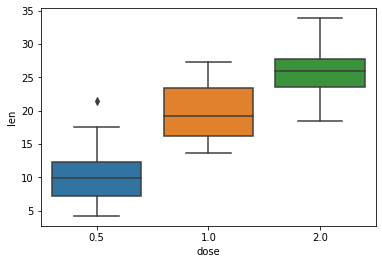

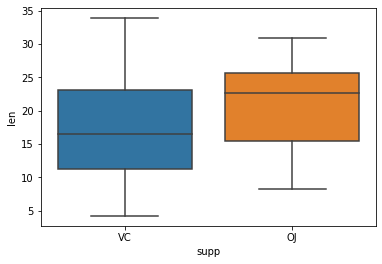

In [46]:
_ = sns.boxplot(x='dose', y='len', data=data)
plt.show()

_ = sns.boxplot(x='supp', y='len', data=data)
plt.show()

### Двухфакторный дисперсионный анализ

#### Без учета межфакторного взаимодействия:

In [47]:
lm = ols('len ~ C(supp) + C(dose)',data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(supp),1.0,205.350000,205.350000,14.016638,4.292793e-04
C(dose),2.0,2426.434333,1213.217167,82.810935,1.871163e-17
Residual,56.0,820.425000,14.650446,NaN,NaN


#### С учетом межфакторного взаимодействия:

In [48]:
lm = ols('len ~ C(supp) * C(dose)', data=data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(supp),1.0,205.350000,205.350000,15.571979,2.311828e-04
C(dose),2.0,2426.434333,1213.217167,91.999965,4.046291e-18
C(supp):C(dose),2.0,108.319000,54.159500,4.106991,2.186027e-02
Residual,54.0,712.106000,13.187148,NaN,NaN


### Межфакторное взаимодействие:

$$X_{ijk} = \mu + \alpha_i + \beta_j + \gamma_{ij} + \varepsilon_{ijk},$$
$$i = 1, ..., K_1,\ j = 1, ..., K_2,\ k = 1, ..., n.$$

- $\mu$ -- общее среднее значение признака,
- $\alpha_i$ -- воздействие уровня $i$ фактора $f_1$,
- $\beta_j$ -- воздействие уровня $j$ фактора $f_2$,
- $\gamma_{ij}$ -- дополнительное воздействие комбинации уровней $i$ и $j$ факторов $f_1$ и $f_2$,
- $\varepsilon_{ijk}$ -- случайные независимые одинаково распределенные ошибки

`sns.pointplot`: 
- точки -- средние значения исследуемого параметра по каждой из групп (значению категориальной переменной)
- 95%-й доверительный интервал

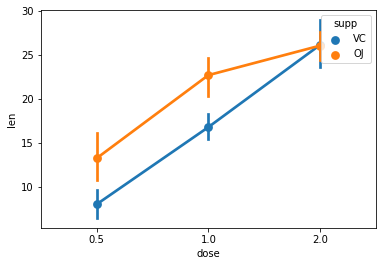

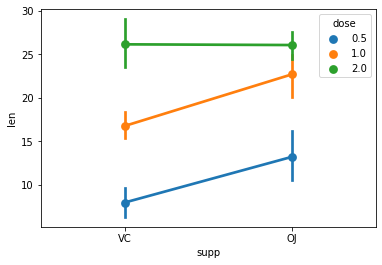

In [49]:
_ = sns.pointplot(x="dose", y="len", data=data, hue='supp')
plt.show()

_ = sns.pointplot(x="supp", y="len", data=data, hue='dose')
plt.show()

Взаимодействие между факторами можно наблюдать, когда результат от воздействия одного фактора на зависимую переменную не одинаков при разных значениях другого фактора.

### Взаимодействие значимо, поэтому разделим выборку по способу приёма витамина.

In [50]:
OJ = data[data['supp']=='OJ']
VC = data[data['supp']=='VC']
VC.shape, OJ.shape

((30, 3), (30, 3))

#### Для морских свинок, принимающих аскорбиновую кислоту:

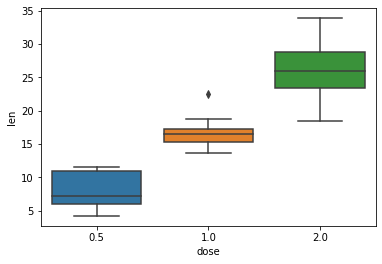

In [51]:
_ = sns.boxplot(x='dose', y='len', data=VC)
plt.show()

In [52]:
lm = ols('len ~ C(dose)',data=VC).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,1649.488667,824.744333,67.072379,3.357317e-11
Residual,27.0,332.001000,12.296333,NaN,NaN


Для морских свинок, принимающих аскорбиновую кислоту влияние разных уровней фактора дозы различно.

##### Критерий Краскела-Уоллиса о равенстве средних всех групп

In [53]:
st.kruskal(*VC.groupby('dose').groups.values())

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)

##### Исследуем попарные различия в воздействии на целевой признак между всеми уровнями фактора дозы

In [55]:
mc = MultiComparison(VC['len'], VC['dose'])
result = mc.tukeyhsd()
 
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.5    1.0     8.79 0.001  4.9025 12.6775   True
   0.5    2.0    18.16 0.001 14.2725 22.0475   True
   1.0    2.0     9.37 0.001  5.4825 13.2575   True
---------------------------------------------------


Значимые различия во влиянии на целевую переменную есть между каждой парой групп

#### Для морских свинок, принимающих апельсиновый сок:

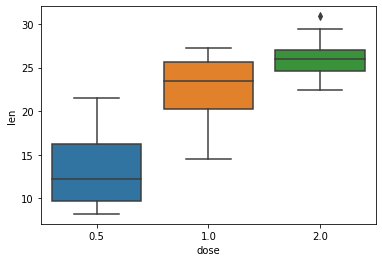

In [56]:
_ = sns.boxplot(x='dose', y='len', data=OJ)
plt.show()

In [57]:
lm = ols('len ~ C(dose)',data=OJ).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,885.264667,442.632333,31.441504,8.887164e-08
Residual,27.0,380.105000,14.077963,NaN,NaN


Отвергаем гипотезу о том, что каждый уровень фактора дозы вносит одинаковый вклад в целевую переменную

##### Исследуем попарные различия в воздействии на целевой признак между всеми уровнями фактора дозы

In [58]:
mc = MultiComparison(OJ['len'], OJ['dose'])
result = mc.tukeyhsd()
 
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.5    1.0     9.47  0.001  5.3104 13.6296   True
   0.5    2.0    12.83  0.001  8.6704 16.9896   True
   1.0    2.0     3.36 0.1308 -0.7996  7.5196  False
----------------------------------------------------


Значимые отличия в воздействии на целевой признак отсутствуют только между 1 и 2

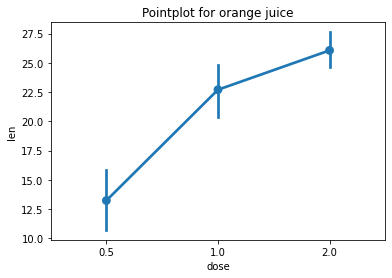

In [59]:
_ = sns.pointplot(x="dose", y="len", data=OJ)
plt.title('Pointplot for orange juice')
plt.show()

### Итого

- для морских свинок, принимающих аскорбиновую кислоту, различия между размером дозы значимы всегда
- для морских свинок, принимающих апельсиновый сок, различия между размером дозы в 1 и 2 мг не значимо

## Марихуана и скорость реакции


Изучалось воздействие марихуаны на скорость реакции. 
В качестве испытуемых
были выбраны по 12 человек из каждой категории:
* никогда не пробовали марихуану;
* иногда употребляют марихуану;
* регулярно употребляют марихуану.

Испытуемые были разделены на две равные группы; половине из них дали
выкурить две сигареты с марихуаной, вторая половина выкурила две обычные
сигареты с запахом и вкусом марихуаны. Сразу после этого все испытуемые прошли
тест на скорость реакции.
Требуется оценить влияние марихуаны на скорость реакции, учитывая фактор
предыдущего опыта употребления.

In [60]:
data = pd.read_csv('data/weed.txt', delimiter='\t')
data.sample(5)

,Placebo/Marijuana,None,Light,Moderate
0,1,795,800,790
1,1,605,705,600
2,1,700,610,695
3,1,752,757,752
4,1,648,645,634


In [61]:
data.describe()

,Placebo/Marijuana,None,Light,Moderate
count,12.000000,12.000000,12.000000,12.000000
mean,1.500000,790.416667,733.416667,739.166667
std,0.522233,110.027648,70.766528,101.902657
min,1.000000,605.000000,610.000000,600.000000
25%,1.000000,707.500000,695.000000,680.000000
50%,1.500000,803.000000,735.000000,739.500000
75%,2.000000,868.250000,782.000000,784.000000
max,2.000000,965.000000,843.000000,983.000000


In [63]:
placebo = data[data['Placebo/Marijuana']==1]
placebo.sample(5)

,Placebo/Marijuana,None,Light,Moderate
1,1,605,705,600
5,1,710,712,705
0,1,795,800,790
3,1,752,757,752
2,1,700,610,695


In [64]:
weed = data[data['Placebo/Marijuana']==2]
weed.sample(5)

,Placebo/Marijuana,None,Light,Moderate
8,2,865,713,735
11,2,840,665,635
6,2,965,843,983
7,2,878,765,744
9,2,916,776,782


Переведем выборку в более адекватное представление: один объект == один человек

In [71]:
new_data = []
for i in data.values:
    new_data.append({'placebo': i[0]==1, 'time': i[1], 'type':'none'})
    new_data.append({'placebo': i[0]==1, 'time': i[2], 'type':'light'})
    new_data.append({'placebo': i[0]==1, 'time': i[3], 'type':'moderate'})
new_data = pd.DataFrame(new_data)
new_data.sample(5)

,placebo,time,type
6,True,700,none
0,True,795,none
8,True,695,moderate
21,False,878,none
12,True,648,none


In [72]:
len(new_data)

36

### Посмотрим распределение времени реакции

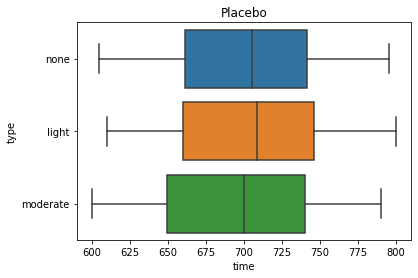

In [73]:
sns.boxplot(data=new_data[new_data['placebo']==True], x='time', y='type' )
_ = plt.title('Placebo')
plt.show()

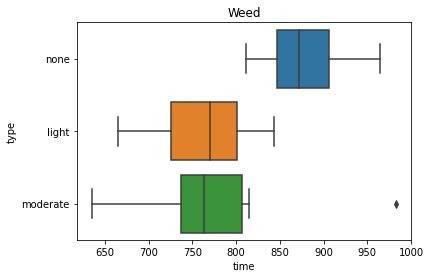

In [74]:
sns.boxplot(data=new_data[new_data['placebo']==False], x='time', y='type' )
_ = plt.title('Weed')
plt.show()

### Дисперсионный анализ

#### Двухфакторный анализ (плацебо + тип курильщика)

In [78]:
lm = ols('time ~ C(type) * C(placebo)',  data=new_data).fit()

##### Что произошло?

$$X_{ijk} = \mu + \alpha_i + \beta_j + \gamma_{ij} + \varepsilon_{ijk},$$
$$i = 1, ..., K_1,\ j = 1, ..., K_2,\ k = 1, ..., n.$$

- $\mu$ -- общее среднее значение признака,
- $\alpha_i$ -- воздействие уровня $i$ фактора $f_1$,
- $\beta_j$ -- воздействие уровня $j$ фактора $f_2$,
- $\gamma_{ij}$ -- дополнительное воздействие комбинации уровней $i$ и $j$ факторов $f_1$ и $f_2$,
- $\varepsilon_{ijk}$ -- случайные независимые одинаково распределенные ошибки

- ```ols``` -- метод наименьших квадратов для задачи регрессии
- Внутри используется формула из ```patsy``` ([описание синтаксиса формул patsy](https://patsy.readthedocs.io/en/latest/formulas.html#formulas))

Краткий экскурс в формулы ```patsy```.

- Формула разделяется на:
    - левую часть: ```time``` -- целевой признак
    - правую часть: ```C(type) + C(placebo) + C(placebo):C(type)``` -- выражение, состоящее из факторов, чьё воздействие на целевой признак мы исследуем, и некоторых операций
- `~` -- разделение левой и правой части
- `+` -- берем во внимание только сами признаки, не учитывая их внутренние взаимодействия ($A \cup B \backslash A \cap B$)
- `:` -- берем во внимание только внутренние взаимодействия между признаками ($A \cap B$)
- `*` -- берем во внимание как сами признаки, так и их внутренние взаимодействия ($A \cup B$)
- `С(...)` -- категориальный признак

Можно посмотреть различную информацию о полученной модели

In [79]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     5.130
Date:                Tue, 16 Mar 2021   Prob (F-statistic):            0.00162
Time:                        18:26:23   Log-Likelihood:                -203.97
No. Observations:                  36   AIC:                             419.9
Df Residuals:                      30   BIC:                             429.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                762.0000     31.251     24.383      0.000     698.176     825.824
C(type)[T.moderate]                       20.3333     44.196      0.460      0.649     -69.927     110.594
C(type)[T.none]                          117.1667     44.196      2.651      0.013      26.906     207.427
C(placebo)[T.True]                       -57.1667     44.196     -1.293      0.206    -147.427      33.094
C(type)[T.moderate]:C(placebo)[T.True]   -29.1667     62.503     -0.467      0.644    -156.814      98.481
C(type)[T.none]:C(placebo)[T.True]      -120.3333     62.503     -1.925      0.064    -247.981       7.314
==============================================================================
Omnibus:                        1.835   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                0.941
Skew:                           0.356   Prob(JB):                        0.625
Kurtosis:                       3.346   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(type),2.0,23634.500000,11817.250000,2.016638,0.150752
C(placebo),1.0,103041.000000,103041.000000,17.584155,0.000224
C(type):C(placebo),2.0,23642.166667,11821.083333,2.017292,0.150665
Residual,30.0,175796.333333,5859.877778,NaN,NaN


In [84]:
lm = ols('time ~ C(placebo)', data=new_data).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(placebo),1.0,103041.0,103041.000000,15.705146,0.00036
Residual,34.0,223073.0,6560.970588,NaN,NaN


In [85]:
lm = ols('time ~ C(type)', data=new_data).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(type),2.0,23634.5,11817.250000,1.289242,0.288993
Residual,33.0,302479.5,9166.045455,NaN,NaN


In [88]:
mc = MultiComparison(new_data['time'], new_data['placebo'])
result = mc.tukeyhsd()
 
print(result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
 False   True   -107.0 0.001 -161.8705 -52.1295   True
------------------------------------------------------


In [98]:
mc = MultiComparison(new_data['time'], new_data['type'])
result = mc.tukeyhsd()
 
print(result)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
   light moderate     5.75    0.9 -90.1406 101.6406  False
   light     none     57.0 0.3241 -38.8906 152.8906  False
moderate     none    51.25 0.4005 -44.6406 147.1406  False
----------------------------------------------------------


#### Критерий Стьюдента о равенстве матожиданий

В предположении о равенстве дисперсий

In [91]:
ttest_ind(new_data[new_data['placebo']==True]['time'], new_data[new_data['placebo']==False]['time'], usevar='pooled')[1]

0.00036003525353863977

Без предположения

In [93]:
ttest_ind(new_data[new_data['placebo']==True]['time'], new_data[new_data['placebo']==False]['time'], usevar='unequal')[1]

0.0004149339054483141

Левосторонняя альтернатива

In [94]:
ttest_ind(new_data[new_data['placebo']==True]['time'], new_data[new_data['placebo']==False]['time'], alternative='smaller', usevar='pooled')[1]

0.00018001762676931988

### Итог:

- факт того, принимал ли человек раньше марихуану, не влияет на его скорость реакции
- при выкуривании марихуаны реакция человека значительно зампедляется